In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pytz 
from scipy.optimize import minimize 
import generate_data
import economic_analysis
import optimization
from importlib import reload 
import pandas as pd
import json
from dataclasses import dataclass
import numpy_financial as npf

### Simulate charging load profile

In [208]:
def simulate_charging_load_profile(total_days, total_time,
                             time_resolution,
                             num_vehicles,
                             charging_power,
                             plot = True):
    '''
    This function simulates a charging load profile for a fleet of EVs at a charging station, given the number of EVs, the charging power, the total simulation time, and the desired time resolution
    
    '''
    
    # Generate random charging start times and durations for each EV
    np.random.seed(42)  # Set a seed for reproducibility
    start_times = np.random.uniform(low=0, high=total_time, size=(num_vehicles, total_days))
    durations = np.random.uniform(low=1, high=4, size=(num_vehicles, total_days))

    # Create the time axis
    time = np.arange(0, total_time, time_resolution)

    # Initialize the load profile
    load_profile = np.zeros_like(time)

    # Calculate the EV load profile for each day
    for i in range(num_vehicles):
        for day in range(total_days):
            start_time = start_times[i, day]
            duration = durations[i, day]
            end_time = start_time + duration

            # Calculate the charging load during the charging period
            mask = (time >= start_time) & (time < end_time)
            load_profile[mask] += charging_power
    if plot: 
        # Plot the EV load profile
        plt.plot(time, load_profile)
        plt.xlabel('Time (hours)')
        plt.ylabel('Power (kW)')
        plt.title('Electric Vehicle Load Profile')
        plt.grid(True)
        plt.show()
    
    return load_profile 

### Define input parameters

In [ ]:

# Financial market inputs
i_no = 0.0775 # interest rate
f = 0.071 # inflation rate
Rproj = 20 # project lifetime (yrs)
discount_rate = 0.05 # discount rate

# Energy market inputs
feed_in_tariff = 0.041 # $/kWh
flat_energy_usage_cost = 0.20 # $/kWh (unused parameter when using ToD)

# Taxi market inputs
cost_per_passenger = 0.5 # $/passenger

# Define time periods (in 10-minute increments since midnight)
morning_start = 5  # 5am
afternoon_start = 11  # 11am
evening_start = 16  # 4pm
night_start = 21  # 9pm
time_periods = {'morning_start': morning_start,
                'afternoon_start': afternoon_start,
                'evening_start': evening_start,
                'night_start': night_start}

# Energy costs for different time periods (e.g., morning, afternoon, evening, night)
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh
time_of_use_tariffs = {'morning': morning_cost,
                       'afternoon': afternoon_cost,
                       'evening': evening_cost,
                       'night': night_cost}

# adjust all the values in time_of_use_tariffs by alpha (adjustment factor)
alpha = 1.5
time_of_use_tariffs = {k: v * alpha for k, v in time_of_use_tariffs.items()}

# Values of kWh in terms of passengers for different time periods 
time_passenger_per_kWh = {'morning': 0.25, 
                          'afternoon': 0.125,
                          'evening': 0.25, 
                          'night': 0.05}
# PV system specifications
pv_efficiency = 0.90  # 85% efficiency
pv_m_sq_per_kw = 6 
pv_cost_per_kw = 4000 # $/kW
pv_annual_maintenance_cost = 20 #$ 

# Inverter, mounting system, and installation costs
inverter_cost = 1000 # $
mounting_cost = 1000 # $
installation_cost = 1000 # $
additional_pv_capital_cost = inverter_cost + mounting_cost + installation_cost

# Environmental inputs
grid_carbon_intensity = 0.95 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2


# Battery parameters
battery_cost_per_kWh = 400 # $/kWh
battery_charging_efficiency = 0.90
battery_discharging_efficiency = 0.90
battery_duration = 6 # hours 
 

# Station constraints
max_land_area = 300 # m^2

# System specifications
loadshedding_probability = 3776 / 8760


# a = {
#     'annual_insolation_profile': annual_insolation_profile,
#     'pv_efficiency': pv_efficiency,
#     'load_profile': load_profile,
#     'flat_energy_usage_cost': flat_energy_usage_cost,
#     'Rproj': Rproj,
#     'pv_cost_per_kw': pv_cost_per_kw,
#     'i_no': i_no,
#     'f': f,
#     'discount_rate': discount_rate,
#     'time_of_use_tariffs': time_of_use_tariffs,
#     'time_periods': time_periods,
#     'feed_in_tariff': feed_in_tariff,
#     'battery_cost_per_kWh': battery_cost_per_kWh,
#     'feed_in_tariff_bool': False,
#     'loadshedding_probability': loadshedding_probability,
#     'time_passenger_per_kWh': time_passenger_per_kWh,
#     'cost_per_passenger': cost_per_passenger,
#     'grid_carbon_intensity': grid_carbon_intensity,
#     'carbon_price': carbon_price,
#     'additional_pv_capital_cost': additional_pv_capital_cost,
#     'pv_m_sq_per_kw': pv_m_sq_per_kw,
#     'max_land_area': max_land_area,
#     'max_battery_capacity': 20


# Financing parameters
loan_upfront_adjustment = 0.50 # 30% of capital cost paid upfront
loan_payback_period = 5 # 10 years for the solar PV system provider to fully recoup their costs

pays_capital_adjustment = 0.30 # 30% of capital cost paid upfront
pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
pays_annual_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


##### LOAD PROFILE
# load_profile = WB_yearly_data
load_profile = load_profile_simulated
# load_profile = load_profile_optimized

#### ICE VEHICLE USAGE ESTIMATES
vehicle_kWh_km = 0.2 # kWh/km
vehicle_km_per_year = vehicle_kWh_km * sum(load_profile)
a  = {
    'annual_insolation_profile': annual_insolation_profile,
    'annual_capacity_factor': annual_capacity_factor,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'pv_annual_maintenance_cost': pv_annual_maintenance_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration,
    'penalty_weight': 1.5,
    # Land area 
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area' : max_land_area,
    # loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_payback_period': pays_payback_period,
    'PAYS_cut_of_savings': pays_cut_of_savings,
    # Cost of capital exponents
    'pv_cost_exponent': 1,
    'battery_cost_exponent': 1,
    'feed_in_tariff_bool': False,
    'renewables_ninja': True,
    'carbon_price_bool': False,
    'load_shedding_bool': False
}

### TODO: 
1. Convert the class attributes from hardcoded to data load in or user input. Extract from passed through dictionary 
2. Update EV annual electricty cost to do time of day calculation
3. Include end of life EV value
4. Include rebuy cost for the vehicle with the shorter lifespan in the main function?

### Data classes
To be made user input or loaded data

In [214]:
@dataclass
class ChargingPort:
    charging_power: float
    charging_cost: float
    charging_efficiency: float
    capex: float 

@dataclass 
class MarketEnvironment:
    interest_rate: float
    inflation_rate: float
    price_diesel: float
    price_electricity: float
    time_of_use_tariffs: dict
    price_diesel_annual_growth_rate: float
    price_electricity_annual_growth_rate: float
    discount_rate: float 

@dataclass    
class FinancingMechanism:
    loan_lifetime: int
    installment_schedule: int
    timeline: int 
    

### Vehicle class

In [237]:
class Vehicle:
    kgCO2_per_liter_gasoline = 2.3 # kgCO2/L
    
    def __init__(self, type: str, params: dict, market_environment, financing_mechanism):
        
        # TODO: Change these to user input or data load from file
        self.type = type
        self.daily_mileage = params['daily_mileage'] # km/day
        self.days_worked_per_week = params['days_worked_per_week'] # days/week
        self.weeks_worked_per_year = params['weeks_worked_per_year'] # weeks/year
        self.fuel_economy = params['fuel_economy'] # L/100km
        self.service_life = params['service_life'] # years
        self.capex = params['capex'] # $/vehicle
        self.down_payment = params['down_payment_fraction'] * self.capex # $/vehicle
        
        # Other operating costs
        self.annual_maintenance_cost = params['annual_maintenance_cost'] # $/year
        self.annual_insurance_cost = params['annual_insurance_cost'] # $/year
        self.annual_taxes = params['annual_taxes'] # $/year
        

        
        # data classes
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
        
    def __repr__(self):
        return f"ICE(id = {repr(self.type)}, daily_mileage = {repr(self.daily_mileage)}, days_worked_per_week = {repr(self.days_worked_per_week)}, weeks_worked_per_year = {repr(self.weeks_worked_per_year)}, fuel_economy = {repr(self.fuel_economy)}, annual_maintenance_cost = {repr(self.annual_maintenance_cost)})"  
        
    ### Computed properties
    @property
    def loan_amount(self):
        return self.capex - self.down_payment
    
    @property
    def annual_mileage(self):
        return self.daily_mileage * self.days_worked_per_week * self.weeks_worked_per_year
    
    @property 
    def annual_fuel_consumption(self):
        return self.annual_mileage * self.fuel_economy / 100
    
    @property 
    def annual_carbon_emissions(self):
        return self.annual_fuel_consumption * Vehicle.kgCO2_per_liter_gasoline
       
    
    # Costs
    
    @property 
    def amortization_schedule(self):
        loan_amount = -self.loan_amount
        interest_rate_per_period = self.market_environment.interest_rate / self.financing_mechanism.installment_schedule
        periods = self.financing_mechanism.loan_lifetime * self.financing_mechanism.installment_schedule # monthly payback
        n_periods = np.arange(periods) + 1
    
        ##### BUILD AMORTIZATION SCHEDULE #####
        # Interest 
        interest_monthly = npf.ipmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Principal 
        principal_monthly = npf.ppmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Join data in dataframe
        df = pd.DataFrame({
            'Period': n_periods,
            'Interest': interest_monthly,
            'Principal': principal_monthly
        })
    
        # Monthly Loan Payment
        df['Payment'] = df['Interest'] + df['Principal']
    
        # Cumsum Loan Payments
        df['Balance'] = df['Payment'].cumsum()
    
        # Reverse vals to pay down balance
        df['Balance'] = df['Balance'].values[::-1]
    
        return df
    
    @property 
    def capital_financing_costs(self):
        cap_fin_cost = np.zeros(self.financing_mechanism.timeline)
        cap_fin_cost[0] = -self.capex
        annual_loan_payment = self.amortization_schedule.iloc[0:self.financing_mechanism.installment_schedule].sum()['Payment']
        cap_fin_cost[1:self.financing_mechanism.loan_lifetime + 1] = annual_loan_payment
        return cap_fin_cost
    
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.market_environment.price_diesel * self.annual_fuel_consumption)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_diesel_annual_growth_rate)**(idx-1)
        
        return operating_cost_fuel

    @property
    def operating_cost_other(self):
        operating_cost_other = np.full(self.service_life, self.annual_insurance_cost + self.annual_maintenance_cost + self.annual_taxes)
        operating_cost_other[0] = 0 # 0 operating costs in year 0 (before the purchase is made)
        
        return operating_cost_other
    
    @property
    def operating_cost_total(self):
        return self.operating_cost_fuel + self.operating_cost_other
    
    @property
    def annual_costs(self):
        # identify which list is shorter between self.capital_financing_Costs and self.operating_Cost_total
        # if self.capital_financing_costs is shorter, pad it with zeros
        # if self.operating_cost_total is shorter, pad it with zeros
        # sum the two lists
        # return the sum
        
        capital_financing_costs = self.capital_financing_costs
        operating_cost_total = self.operating_cost_total
        
        if len(capital_financing_costs) <= len(operating_cost_total):
            capital_financing_costs = np.pad(capital_financing_costs, (0, len(operating_cost_total) - len(capital_financing_costs)), 'constant')
        else:
            operating_cost_total = np.pad(operating_cost_total, (0, len(capital_financing_costs) - len(operating_cost_total)), 'constant')
        
    
        return [cap_fin_cost + op_cost for cap_fin_cost, op_cost in zip(capital_financing_costs, operating_cost_total)]
    
    
    def get_annual_discounted_costs(self):
            
        cost_annual_discounted = self.annual_costs
        
        for year in range(len(cost_annual_discounted)):
            cost_annual_discounted[year] = cost_annual_discounted[year] * (1/(1+self.market_environment.discount_rate))**year
    
        return cost_annual_discounted
    
    # TODO: Add depreciation schedule
    def get_end_of_life_value(self):   
        return 0
    

### EV subclass

In [241]:
class EV(Vehicle):
    kgco2_per_kwh = 0.95 # kgCO2/kWh
    

    def __init__(self, type, params: dict, charging_port, market_environment, financing_mechanism):
        super().__init__(type, params, market_environment, financing_mechanism)
        self.efficiency = params['efficiency'] # kWh/km
        self.battery_capacity = params['battery_capacity'] # kWh
        self._charging_profile = None # kWh
        
        # data classes
        self.charging = charging_port
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
    def __repr__(self):
        return f"EV(id={repr(self.type)}, battery_capacity={repr(self.battery_capacity)}, charging_power={repr(self.charging_power)})"
    
    # Charging power 
    @property 
    def charging_power(self):
        return self._charging_power
    
    @charging_power.setter
    def charging_power(self, charging_power):
        self._charging_profile = None # reset charging profile when charging power is changed 
        self._charging_power = charging_power
        
    # Battery capacity 
    @property 
    def battery_capacity(self):
        return self._battery_capacity
    
    @battery_capacity.setter
    def battery_capacity(self, charging_power):
        self._charging_profile = None # reset charging profile when battery capacity is changed 
        self._battery_capacity = charging_power
        
        
    # Charging profile (simulated or data loaded)
    @property 
    def charging_profile(self):
        # cache 
        if self._charging_profile is None: 
            # total_time = 24 * 3600 * 365  # 24 hours
            # time_resolution = 3600  # 1 hour
            total_days = 365  # Total number of days to simulate
            total_time = 24 * total_days  # Total simulation time in hours
            time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
            self._charging_profile = simulate_charging_load_profile(total_days, total_time, time_resolution, 1, 8, plot = False)
        return self._charging_profile
        
    # Monetary costs
    @property
    def annual_electricity_costs(self):
        return sum(self.charging_profile) * self.market_environment.price_electricity
        
        
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.annual_electricity_costs)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_electricity_annual_growth_rate)**(idx-1)
                

        return operating_cost_fuel


    # Carbon emissions 
    @property 
    def annual_carbon_emissions(self):
        kWh_used = sum(self.charging_profile)
        return kWh_used * EV.kgco2_per_kwh
    
    
        


        

### Functions

In [239]:

# Inputs: arrays of annual discounted costs for EV and ICE, and length of time to plot
# Outputs: line plot of cumulative costs (discounted) of EV and ICE over time period
def plot_cumulative_costs(EV, ICE):
    costs_EV = EV.get_annual_discounted_costs()
    costs_ICE = ICE.get_annual_discounted_costs()
    years  = np.arange(0, len(costs_EV))
    plt.title("Cumulative Costs ($), \n EV (retrofit) vs ICE (refurbished)", size = 18)
    plt.xlabel("Years")
    plt.ylabel("Cost ($)")
    plt.plot(years[1:], np.cumsum(costs_EV[1:]), color = 'blue', label = 'EV', marker = 'o')
    plt.plot(years[1:], np.cumsum(costs_ICE[1:]), color = 'red', label = 'ICE', marker = 'o')
    plt.legend()
    plt.show()

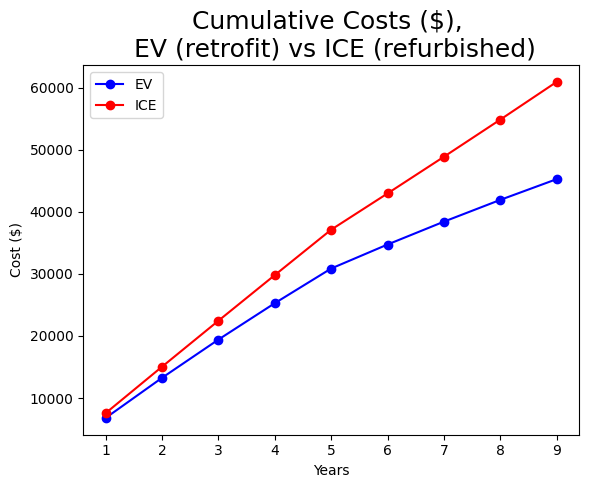

In [242]:

vehicle_params = {'daily_mileage': 100, 'days_worked_per_week': 5, 'weeks_worked_per_year': 50, 'fuel_economy': 10, 'service_life': 10, 'capex': 10000, 
                  'down_payment_fraction': 0.2, 'annual_maintenance_cost': 1000, 'annual_insurance_cost': 1000, 'annual_taxes': 1000, 
                  'efficiency': 0.2, 'battery_capacity': 30}

charging_port1 = ChargingPort(7.2, 0.2, 0.9, 10000)
market_environment1 = MarketEnvironment(0.08, 0.02, 1.20, 0.30, None, 0.10, 0, 0.05)
financing_mechanism1 = FinancingMechanism(5, 12, 6)


vehicle1 = Vehicle(1, vehicle_params, market_environment = market_environment1, financing_mechanism = financing_mechanism1)
ev1 = EV(vehicle1, vehicle_params, charging_port1, market_environment1, financing_mechanism1)

plot_cumulative_costs(ev1, vehicle1)